# Brightfield-Brightfield Linear Image Registration
This notebook is adapted from https://github.com/airlab-unibas/airlab/blob/master/examples/affine_registration_3d.py

- Fixed image: MD589
- Moving image: MD594

In [1]:
import airlab as al
import numpy as np
import torch

import utility as util

## Load images

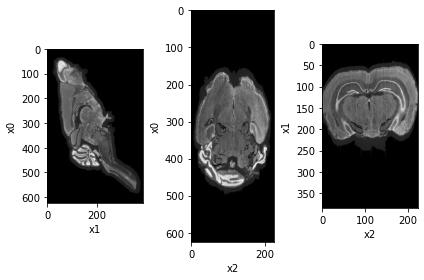

In [2]:
fixed_image = np.load('../data/bb/fixed_image.npy')
fixed_image = util.normalize_intensity(fixed_image)
util.imshow_midslice(fixed_image)

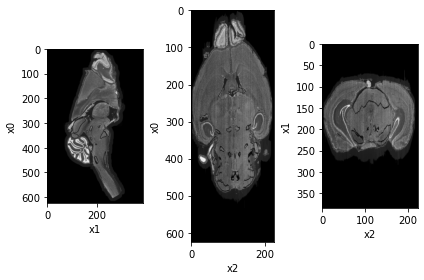

In [3]:
moving_image = np.load('../data/bb/moving_image.npy')
moving_image = util.normalize_intensity(moving_image)
util.imshow_midslice(moving_image)

## Prepare images for registration

In [4]:
dtype = torch.float32
device = torch.device('cpu')
scales = [1, 1, 1]

fixed_image = torch.tensor(fixed_image, dtype=dtype).to(device)
fixed_image = al.Image(fixed_image, fixed_image.shape, scales, [0, 0, 0])
moving_iamge = torch.tensor(moving_image, dtype=dtype).to(device)
moving_image = al.Image(moving_image, moving_image.shape, scales, [0, 0, 0])

## Prepare image pyramid

In [5]:
scales = [[4, 4, 4], [2, 2, 2]]

fixed_image_pyramid = al.create_image_pyramid(fixed_image, scales)
moving_image_pyramid = al.create_image_pyramid(moving_image, scales)

## Run registration

In [6]:
lr = 5e-3
niter = [64, 16, 4]

In [7]:
import time

start = time.time()

for level, (mov_im, fix_im) in enumerate(zip(moving_image_pyramid, fixed_image_pyramid)):
    print('level', level)
    registration = al.PairwiseRegistration(verbose=True)
    
    transformation = al.transformation.pairwise.AffineTransformation(mov_im)
    if level == 0:
        transformation.init_translation(fix_im)
    else:
        transformation.set_parameters(**parameters)
    registration.set_transformation(transformation)
    
    image_loss = al.loss.pairwise.MSE(fix_im, mov_im)
    registration.set_image_loss([image_loss])
    
    optimizer = torch.optim.Adam(transformation.parameters(), lr=lr)
    registration.set_optimizer(optimizer)
    
    registration.set_number_of_iterations(niter[level])
    registration.start()
    
    parameters = {
        't': (
            float(transformation._t_x),
            float(transformation._t_y),
            float(transformation._t_z)
        ),
        'phi': (
            float(transformation._phi_z),
            float(transformation._phi_x),
            float(transformation._phi_y),
        ),
        'scale': (
            float(transformation._scale_x),
            float(transformation._scale_y),
            float(transformation._scale_z)
        ),
        'shear': (
            float(transformation._shear_y_x),
            float(transformation._shear_x_y),
            float(transformation._shear_z_x),
            float(transformation._shear_z_y),
            float(transformation._shear_x_z),
            float(transformation._shear_y_z),
        ),
    }

end = time.time()
print((end - start) / 60, 'min')

level 0
0 mse: 0.015886414359412612 
1 

/home/b2dong/registration-study/env/lib/python3.8/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/b2dong/registration-study/env/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


mse: 0.015960479053216077 
2 mse: 0.015642525587107617 
3 mse: 0.01538638415366065 
4 mse: 0.015131498394776751 
5 mse: 0.014949776166883826 
6 mse: 0.014717003791014743 
7 mse: 0.014483574213483348 
8 mse: 0.014191032445345543 
9 mse: 0.01396534077014201 
10 mse: 0.0137398333795548 
11 mse: 0.013542956511128421 
12 mse: 0.013367414166412097 
13 mse: 0.013212316623934135 
14 mse: 0.013028494626975353 
15 mse: 0.012883443619128365 
16 mse: 0.012725720971506049 
17 mse: 0.012579200545388481 
18 mse: 0.012414541878051253 
19 mse: 0.012250721539024833 
20 mse: 0.012096683021675289 
21 mse: 0.011932048566581335 
22 mse: 0.011779392970646868 
23 mse: 0.011621021962929785 
24 mse: 0.011462424827261192 
25 mse: 0.011312749101698131 
26 mse: 0.011148216942839012 
27 mse: 0.01096982623853372 
28 mse: 0.010794246952028578 
29 mse: 0.01061269118949793 
30 mse: 0.010441908638272329 
31 mse: 0.010272505704146744 
32 mse: 0.010096509415007074 
33 mse: 0.009914833640741319 
34 mse: 0.00973428324175137

## Examine results

In [8]:
transformation.print()

_phi_z 0.022213134988940973
_t_x 0.009049052100956826
_t_y 0.09538842547623946
_t_z -0.014494352172380782
_phi_x 0.3934553066249431
_phi_y 0.04575376108693991
_scale_x 0.9694329256688745
_scale_y 0.9660710578420617
_scale_z 1.1704712307445422
_shear_y_x -0.026416169495779834
_shear_x_y 0.021708946420347774
_shear_z_x 0.06839794618245054
_shear_z_y -0.33350323516874736
_shear_x_z 0.0007033819221718128
_shear_y_z -0.11449366114878726


In [9]:
displacement = transformation.get_displacement()
warped_image = al.transformation.utils.warp_image(moving_image, displacement)
np.save('../data/bb/moving_image_after_linear_reg.npy', warped_image.image[0,0].numpy())

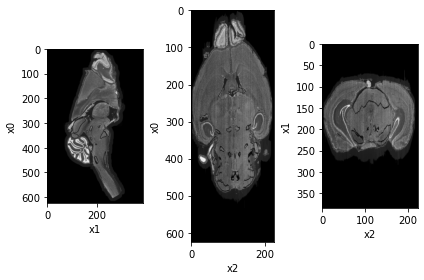

In [10]:
util.imshow_midslice(moving_image.image[0,0].numpy())

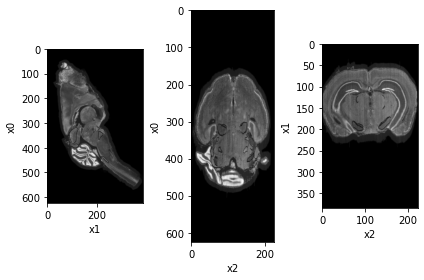

In [11]:
util.imshow_midslice(warped_image.image[0,0].numpy())

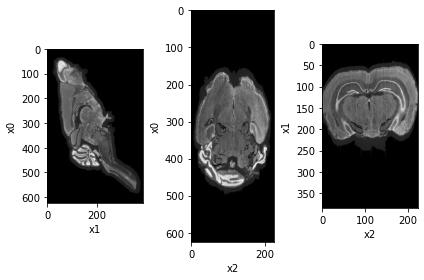

In [12]:
util.imshow_midslice(fixed_image.image[0,0].numpy())